# Wind Power Forecasting - Random Forest ma model
* Moving Average - Rolling Mean 

In [9]:
import numpy as np
import pandas as pd
import joblib
import csv
from math import sqrt
import datetime as dt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from time import strftime
import matplotlib.pyplot as plt
%matplotlib inline

# import data


In [10]:
df = pd.read_csv(r'C:\Users\dabre\OneDrive\Desktop\WindForecasting_CapstoneProject\data1\wf1.csv', 
index_col=0, parse_dates=True)

new_index = [] 
for stamp in df.index: 
    new = '2' + stamp[1:] 
    new_index.append(new)

df.index = pd.to_datetime(new_index)

df = df[['PowerGeneration',
'ForecastingTime', 'AirPressure', 'Temperature', 'Humidity', 'WindSpeed100m', 'WindSpeed10m', 'WindDirectionZonal', 
'WindDirectionMeridional']]

df.head(2)

,PowerGeneration,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional
2000-01-01 01:00:00,0.506970,25,0.392238,0.406113,0.638134,0.625094,0.548931,0.820776,0.883540
2000-01-01 02:00:00,0.579394,26,0.379920,0.405190,0.614377,0.628325,0.563099,0.812227,0.890531


# Histogram of Power Generation

* Histogram of wind farm power generation output.  
* Power generation time series are normalized with the respective nominal capacity of the wind farm. i.e., power generation is expressed as a fraction of total wind farm capacity.


In [11]:
# fraction of zero power output
pg_zeros = (df['PowerGeneration']==0).sum()
pg_count = (df['PowerGeneration']).count()
zero_fraction = round(pg_zeros/pg_count,3)
zero_fraction

0.091

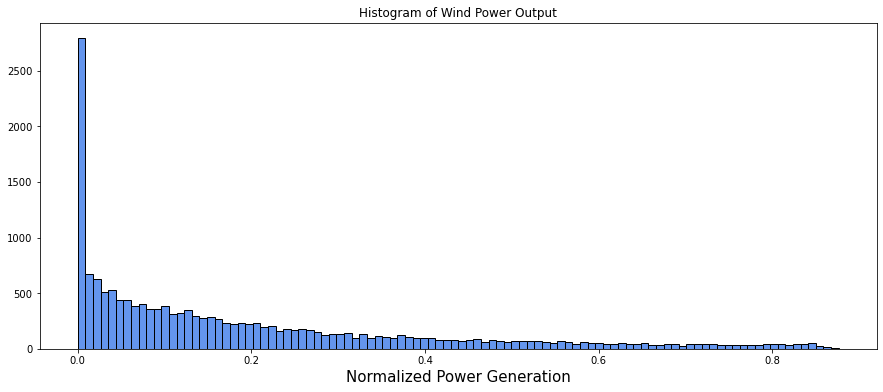

In [12]:
x = df['PowerGeneration']
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(15,6) )
axes.hist(x, bins=100, range=None, histtype='bar', align='mid',
          orientation='vertical', log=False, color='cornflowerblue', edgecolor='k', label=None)
axes.set_xlabel("Normalized Power Generation", fontsize=15)
plt.title('Histogram of Wind Power Output')
plt.ylabel('')
plt.show()

#fig.savefig('wind_turbine_outputs.png', dpi=200, bbox_inches='tight')

__Power Generation Histogram Analysis__

The histogram displays two noteworthy features: a large spike near 0, and a bump near 1. 
* The zero spike correlates with low wind velocities. Turbines cannot generate power if the wind speed falls below a threshold known as the cut-in speed.

Cut-in speed
At very low wind speeds, there is insufficient torque exerted by the wind on the turbine blades to make them rotate. As the speed increases, the wind turbine will begin to rotate and generate electrical power. The speed at which the turbine first starts to rotate and generate power is called the cut-in speed and is typically between 3 and 4 metres per second.

Fraction of power generation equal to zero: 9.1%

* The bump near one corresponds to turbines working near full capacity. 

# Import Rolling Average Feature Data

In [13]:
df = pd.read_csv(r'C:\Users\dabre\OneDrive\Desktop\WindForecasting_CapstoneProject\data1\wf_rm3.csv', 
index_col=0, parse_dates=True)

df = df[['PowerGeneration',
 'ForecastingTime',
 'AirPressure',
 'Temperature',
 'Humidity',
 'WindSpeed100m',
 'WindSpeed10m',
 'WindDirectionZonal',
 'WindDirectionMeridional',
'PowerGeneration_rm3']]

df.head(2)

,PowerGeneration,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional,PowerGeneration_rm3
Time,,,,,,,,,,
0000-01-01 01:00:00,0.506970,25,0.392238,0.406113,0.638134,0.625094,0.548931,0.820776,0.883540,0.5069
0000-01-01 02:00:00,0.579394,26,0.379920,0.405190,0.614377,0.628325,0.563099,0.812227,0.890531,0.5100


In [14]:
df.columns

Index(['PowerGeneration', 'ForecastingTime', 'AirPressure', 'Temperature',
       'Humidity', 'WindSpeed100m', 'WindSpeed10m', 'WindDirectionZonal',
       'WindDirectionMeridional', 'PowerGeneration_rm3'],
      dtype='object')

## Data Preprocessing
* Preprocess training data set
* Split data into training and testing sets

In [15]:
# Split Features and Targets
X = df.iloc[:,1:10]
y = df.iloc[:,0]
features = df.columns.values.tolist()
features.remove('PowerGeneration')
features

['ForecastingTime',
 'AirPressure',
 'Temperature',
 'Humidity',
 'WindSpeed100m',
 'WindSpeed10m',
 'WindDirectionZonal',
 'WindDirectionMeridional',
 'PowerGeneration_rm3']

In [16]:
# Non Shuffle test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print('Size of data set for training: {0}, for testing: {1}\n'.format(len(y_train), len(y_test)))

print('Train Features Shape:', X_train.shape)
print('Train Target Shape:', y_train.shape)
print('Test Features Shape:', X_test.shape)
print('Test Target Shape:', y_test.shape)

Size of data set for training: 11844, for testing: 5076

Train Features Shape: (11844, 9)
Train Target Shape: (11844,)
Test Features Shape: (5076, 9)
Test Target Shape: (5076,)


## Fit Random Forest Model

In [17]:
'''
Fit random forest model to training subset of training data set.
'''

rfr_train = RandomForestRegressor(n_estimators=1000, criterion="mse", max_depth=40, min_samples_split=2, 
                                  min_samples_leaf=3, max_features="sqrt", max_leaf_nodes=None, bootstrap=True,
                                  oob_score=False, n_jobs=-1, random_state=0, verbose=0)
%time rfr_train.fit(X_train, y_train)

Wall time: 6.19 s


RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=1000, n_jobs=-1, random_state=0)

## Evaluate Random Forest Fit Results

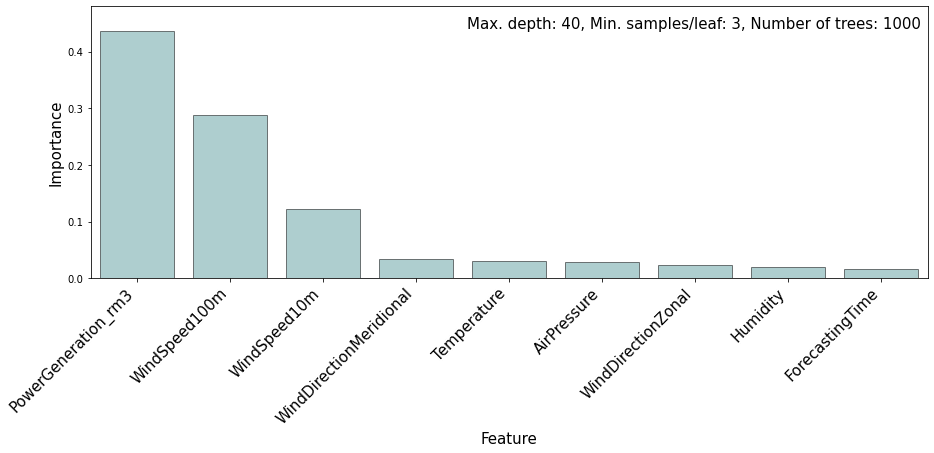

In [18]:
'''
Evaluate fit results.
'''

# Plot feature importances, sorted in decreasing order
importances = rfr_train.feature_importances_
indices     = np.argsort(importances)[::-1]
n_features  = indices.size
bins        = np.arange(n_features)
x_labels    = np.array(features)[indices][:n_features]
maxHeight   = 1.10*max(importances)

fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.bar(bins, importances[indices][:n_features], align="center", color="cadetblue", edgecolor="k", alpha=0.5)
axes.set_xlabel("Feature", fontsize=15)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=15)
axes.set_xlim([-0.5,bins.size-0.5])
axes.set_ylabel("Importance", fontsize=15)
axes.set_ylim([0.0, maxHeight])
rfr_parameters = rfr_train.get_params()
mx_dpth = rfr_parameters['max_depth']
mn_s_lf = rfr_parameters['min_samples_leaf']
n_trees = rfr_parameters['n_estimators']
axes.text(0.45, 0.92, 
          'Max. depth: {0}, Min. samples/leaf: {1}, Number of trees: {2}'.format(mx_dpth,mn_s_lf,n_trees),
          fontsize=15, transform=axes.transAxes)
plt.show()
fig.savefig('rfr_ma_feature_importances_ma5.png', dpi=200, bbox_inches='tight')


## Validation Error Scores
* Get error scores: RMSE, MAE

## Forecasting Accuracy
__Error__
* The forecast error (residual) is the difference between the actual time series value and the forecast value for the corresponding period.
* A good forecasting method will yield residuals that are uncorrelated.  
* A good forecasting method will also have zero mean.  If the residuals have a mean other than zero, then the forecasts are biased.

__Aggregate Error__

__RMSE__
* The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a measure of the differences between values predicted by a model and the values observed. 

* The RMSE represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation and are called prediction errors when computed out-of-sample. 

* The RMSE serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.

* RMSD is the square root of the average of squared errors. The effect of each error on RMSD is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSD. Consequently, RMSD is sensitive to outliers.

__MAE__
* Mean Absolute Error (MAE) is a measure of difference between two continuous variables. 

* MAE possesses advantages in interpretability over RMSE. MAE is the average of the absolute values of the errors. MAE is fundamentally easier to understand than the square root of the average of squared errors. Furthermore, each error influences MAE in direct proportion to the absolute value of the error, which is not the case for RMSE.


In [19]:
# Compute root mean squared errors on train (residuals and test (prediction errors) sets.

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

y_train_pred = rfr_train.predict(X_train)
y_test_pred  = rfr_train.predict(X_test)

rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))



RMSE on train data set: 0.04729311113776412
RMSE on test data set:  0.08392433775069653


In [20]:
# Compute mean absolute error on train and test sets.

from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)

print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))



MAE on train data set: 0.03207234863851936
MAE on test data set:  0.05707904741245895


## Plot actual vs predicted power
#### Make a histogram of the actual and predicted response variable in the training set.


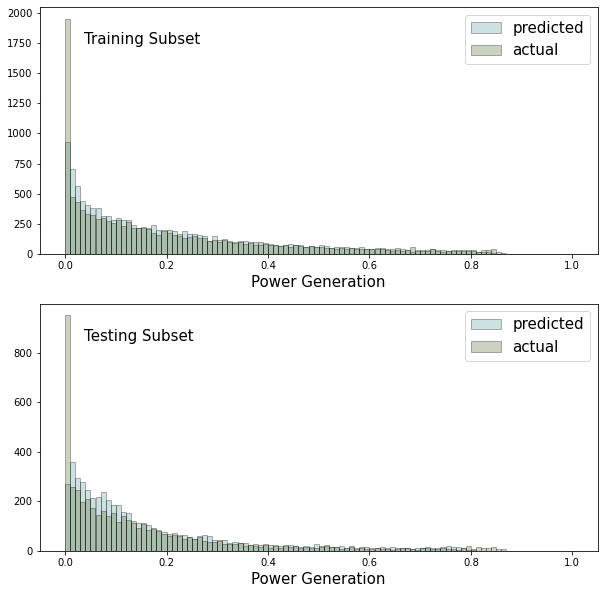

In [21]:
 
actual_targets_train    = y_train
predicted_targets_train = rfr_train.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = rfr_train.predict(X_test)
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.],  histtype='bar', align='mid', 
             orientation='vertical', log=False, color='cadetblue', alpha=0.3, edgecolor='k', label='predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.],  histtype='bar', align='mid', 
             orientation='vertical', log=False, color='darkolivegreen', alpha=0.3, edgecolor='k', label='actual')
axis[0].set_xlabel("Power Generation", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Subset", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.],  histtype='bar', align='mid', 
             orientation='vertical', log=False, color='cadetblue', alpha=0.3, edgecolor='k', label='predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], histtype='bar', align='mid', 
             orientation='vertical', log=False, color='darkolivegreen', alpha=0.3, edgecolor='k', label='actual')
axis[1].set_xlabel("Power Generation", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Subset", fontsize=15, transform=axis[1].transAxes)

plt.show()
fig.savefig('power_generation_rf_train_test_ma5.png', dpi=200, bbox_inches='tight')

## Visualize A Single Decision Tree

In [58]:
features = df.copy(deep=True)

# Labels are target values to predict: PowerGeneration
labels = np.array(features['PowerGeneration'])

# Remove labels from dataset
features = features.drop('PowerGeneration', axis=1)

## Note ~ Sebastian Raschka: tree-based classifier are classifiers where feature scaling doesn’t make a difference.

# Save feature column names
feature_list = list(features.columns)

# convert features to numpy array
features = np.array(features)

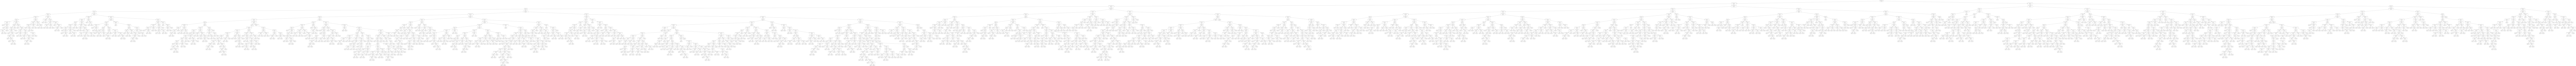

In [59]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Get one tree from the forest
tree = rfr_train.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image
Image('tree.png')

# Predicted vs Actual

In [80]:
y_test_pred  = rfr_train.predict(X_test)
y_test_pred.shape
predicted_power = pd.DataFrame(y_test_pred)

#predicted_power
#predicted_power.iloc[0:500]

actual_power = pd.DataFrame(y_test.values)
#actual_power.iloc[0:500]

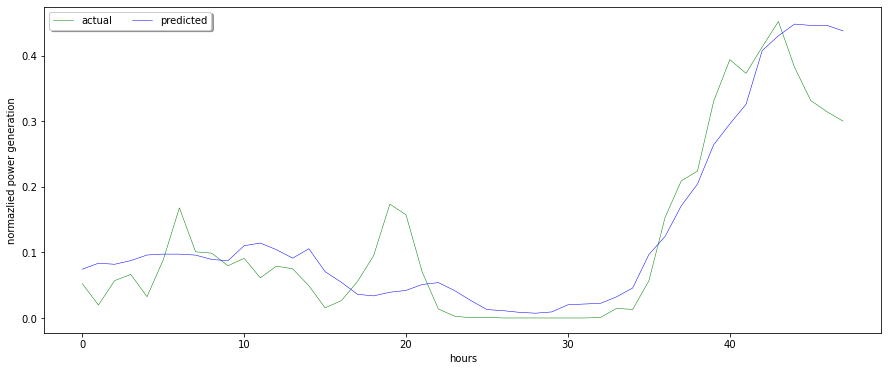

In [81]:
# predicted vs actual
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
#plt.suptitle('Wind Power Generation Actual vs Predicted')
plt.plot(actual_power.iloc[0:48], label="actual", color='green', linewidth=.5)
plt.plot(predicted_power.iloc[0:48], label="predicted", color='blue', linewidth=.5)
plt.ylabel('normazlied power generation')
plt.xlabel('hours')
#legend((line1, line2), ('actual', 'predicted'))
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2, shadow=True, fancybox=True)
fig.savefig('PowerGeneration_actual_predicted_ma5.png', dpi=200, bbox_inches='tight')